In [9]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import tadasets
from sklearn.metrics.pairwise import pairwise_distances
from scipy import sparse
import time

In [39]:
MIN_EPS = 0.5
MAX_EPS = 2
NUM_EPS = 3
RIPS_MAXDIM = 1
SHOW_DATA = True

In [40]:
def getGreedyPerm(D):
    """
    A Naive O(N^2) algorithm to do furthest points sampling

    Parameters
    ----------
    D : ndarray (N, N)
        An NxN distance matrix for points

    Return
    ------
    lamdas: list
        Insertion radii of all points
    """
    N = D.shape[0]
    #By default, takes the first point in the permutation to be the
    #first point in the point cloud, but could be random
    perm = np.zeros(N, dtype=np.int64)
    lambdas = np.zeros(N)
    ds = D[0, :]
    for i in range(1, N):
        idx = np.argmax(ds)
        perm[i] = idx
        lambdas[i] = ds[idx]
        ds = np.minimum(ds, D[idx, :])
    return lambdas[perm]

In [41]:
def getApproxSparseDM(lambdas, eps, D):
    """
    Purpose: To return the sparse edge list with the warped distances, sorted by weight

    Parameters
    ----------
    lambdas: list
        insertion radii for points
    eps: float
        epsilon approximation constant
    D: ndarray
        NxN distance matrix, okay to modify because last time it's used

    Return
    ------
    DSparse: scipy.sparse
        A sparse NxN matrix with the reweighted edges
    """
    N = D.shape[0]
    E0 = (1+eps)/eps
    E1 = (1+eps)**2/eps

    # Create initial sparse list candidates (Lemma 6)
    # Search neighborhoods
    nBounds = ((eps**2+3*eps+2)/eps)*lambdas

    # Set all distances outside of search neighborhood to infinity
    D[D > nBounds[:, None]] = np.inf
    [I, J] = np.meshgrid(np.arange(N), np.arange(N))
    idx = I < J
    I = I[(D < np.inf)*(idx == 1)]
    J = J[(D < np.inf)*(idx == 1)]
    D = D[(D < np.inf)*(idx == 1)]

    #Prune sparse list and update warped edge lengths (Algorithm 3 pg. 14)
    minlam = np.minimum(lambdas[I], lambdas[J])
    maxlam = np.maximum(lambdas[I], lambdas[J])

    # Rule out edges between vertices whose balls stop growing before they touch
    # or where one of them would have been deleted.  M stores which of these
    # happens first
    M = np.minimum((E0 + E1)*minlam, E0*(minlam + maxlam))

    t = np.arange(len(I))
    t = t[D <= M]
    (I, J, D) = (I[t], J[t], D[t])
    minlam = minlam[t]
    maxlam = maxlam[t]

    # Now figure out the metric of the edges that are actually added
    t = np.ones(len(I))

    # If cones haven't turned into cylinders, metric is unchanged
    t[D <= 2*minlam*E0] = 0

    # Otherwise, if they meet before the M condition above, the metric is warped
    D[t == 1] = 2.0*(D[t == 1] - minlam[t == 1]*E0) # Multiply by 2 convention
    return sparse.coo_matrix((D, (I, J)), shape=(N, N)).tocsr()

In [42]:
def make_torus(n, c, a, noise = 0.1):
    rng = np.random.default_rng(28690391)
    precision = int(n ** 0.5)
    U = np.linspace(0, 2*np.pi, precision)
    V = np.linspace(0, 2*np.pi, precision)
    U, V = (np.ravel(dim) for dim in np.meshgrid(U, V))
    X = (c+a*np.cos(V))*np.cos(U) + rng.random(precision**2) * noise * 2 - noise
    Y = (c+a*np.cos(V))*np.sin(U) + rng.random(precision**2) * noise * 2 - noise
    Z = a*np.sin(V) + rng.random(precision**2) * noise * 2 - noise
    return np.array([X, Y, Z]).T

In [213]:
def make_map(n1,n2, noise=0.1):
    rng = np.random.default_rng(28690391)
    precision1 = int(n1)
    precision2 = int(n2)
    t_ar1=np.array(np.linspace(0,0.15,precision1))
    t_ar2=np.array(np.linspace(.2,1,precision2))
    t_ar3=np.array(np.linspace(0,1,precision2))
    t_ar4=np.array(np.linspace(0.5,1.35,precision2))
    t_arvert1=np.full((1, 50), 0.3)+ rng.random(50) * .01 * 2 - .01
    t_arvert2=np.full((1, 50), 0.6)+ rng.random(50) * .01 * 2 - .01
    x0=2*t_ar1-2.3+ rng.random(n1) * noise * 2 - noise
    x1=2*t_ar1-2.4+ rng.random(n1) * noise * 2 - noise
    x2=2*t_ar1-2.5+ rng.random(n1) * noise * 2 - noise
    x3=2*t_ar1-2.6+ rng.random(n1) * noise * 2 - noise
    x4=2*t_ar1-2.7+ rng.random(n1) * noise * 2 - noise
    x5=2*t_ar1-2.8+ rng.random(n1) * noise * 2 - noise
    x6=2*t_ar1-3.5+ rng.random(n1) * noise * 2 - noise
    x7=2*t_ar1-3.6+ rng.random(n1) * noise * 2 - noise
    x8=2*t_ar1-3.7+ rng.random(n1) * noise * 2 - noise
    x9=2*t_ar1-3.8+ rng.random(n1) * noise * 2 - noise
    x10=2*t_ar1-3.9+ rng.random(n1) * noise * 2 - noise
    x11=2*t_ar1-4.0+ rng.random(n1) * noise * 2 - noise
    x12=2*t_ar2-2.3+ rng.random(n2) * noise * 2 - noise
    x13=2*t_ar2-2.4+ rng.random(n2) * noise * 2 - noise
    x14=2*t_ar2-2.5+ rng.random(n2) * noise * 2 - noise
    x15=2*t_ar2-2.6+ rng.random(n2) * noise * 2 - noise
    x16=2*t_ar2-2.7+ rng.random(n2) * noise * 2 - noise
    x17=2*t_ar2-2.8+ rng.random(n2) * noise * 2 - noise
    x18=2*t_ar2-3.5+ rng.random(n2) * noise * 2 - noise
    x19=2*t_ar2-3.6+ rng.random(n2) * noise * 2 - noise
    x20=2*t_ar2-3.7+ rng.random(n2) * noise * 2 - noise
    x21=2*t_ar2-3.8+ rng.random(n2) * noise * 2 - noise
    x22=2*t_ar2-3.9+ rng.random(n2) * noise * 2 - noise
    x23=2*t_ar2-4.0+ rng.random(n2) * noise * 2 - noise
    x_vert1= np.linspace(-3.5,-2,50)+ rng.random(50) * .01 * 2 - .01
    x_vert2= np.linspace(-2.5,-1.5,50)+ rng.random(50) * .01 * 2 - .01
    #other additions to the map we could add
    #x24=-2*t_ar3+1.4+ rng.random(n2) * noise * 2 - noise
    #x25=-2*t_ar3+1.5+ rng.random(n2) * noise * 2 - noise
    #x26=-2*t_ar3+1.6+ rng.random(n2) * noise * 2 - noise
    #x27=-2*t_ar3+1.7+ rng.random(n2) * noise * 2 - noise
    #x28=-2*t_ar3+1.8+ rng.random(n2) * noise * 2 - noise
    #x29=-2*t_ar3+1.9+ rng.random(n2) * noise * 2 - noise
    #x30=-2*t_ar3+2+ rng.random(n2) * noise * 2 - noise
    #x31=-2*t_ar3+2+ rng.random(n2) * noise * 2 - noise
    #x32=-2*t_ar3+2.1+ rng.random(n2) * noise * 2 - noise
    #x33=-2*t_ar3+2.2+ rng.random(n2) * noise * 2 - noise
    #x34=-2*t_ar3+2.3+ rng.random(n2) * noise * 2 - noise
    #x35=-2*t_ar3+2.4+ rng.random(n2) * noise * 2 - noise
    #x36=-2*t_ar3+2.5+ rng.random(n2) * noise * 2 - noise
    #x37=-2*t_ar3+2.6+ rng.random(n2) * noise * 2 - noise
    tot_time=np.concatenate((t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1, t_ar2, t_ar2,t_ar2,t_ar2,t_ar2,t_ar2,t_ar2,t_ar2,t_ar2,t_ar2,t_ar2,t_ar2, t_arvert1[0]))#,t_arvert2[0]))
                            #,t_ar3,t_ar3,t_ar3,t_ar3,t_ar3,t_ar3,t_ar3,t_ar4,t_ar4,t_ar4,t_ar4,t_ar4,t_ar4,t_ar4))
    tot_pos=np.concatenate((x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22, x23, x_vert1))#, x_vert2))#,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37))   
    
    
    
    
    return np.array([tot_time, tot_pos]).T

In [214]:
def make_map2(n1,n2, noise=0.1):
    rng = np.random.default_rng(28690391)
    precision1 = int(n1)
    precision2 = int(n2)
    t_ar1=np.array(np.linspace(0,1,precision1))
    t_ar2=np.array(np.linspace(1.2,2,precision2))
    t_ar3=np.array(np.linspace(0,1,precision2))
    t_ar4=np.array(np.linspace(0.5,1.35,precision2))
    t_arvert1=np.full((1, 50), 0.3)+ rng.random(50) * .01 * 2 - .01
    t_arvert2=np.full((1, 50), 0.6)+ rng.random(50) * .01 * 2 - .01
    x0=2*t_ar1-2.3+ rng.random(n1) * noise * 2 - noise
    x1=2*t_ar1-2.4+ rng.random(n1) * noise * 2 - noise
    x2=2*t_ar1-2.5+ rng.random(n1) * noise * 2 - noise
    x3=2*t_ar1-2.6+ rng.random(n1) * noise * 2 - noise
    x4=2*t_ar1-2.7+ rng.random(n1) * noise * 2 - noise
    x5=2*t_ar1-2.8+ rng.random(n1) * noise * 2 - noise
    x6=2*t_ar1-3.5+ rng.random(n1) * noise * 2 - noise
    x7=2*t_ar1-3.6+ rng.random(n1) * noise * 2 - noise
    x8=2*t_ar1-3.7+ rng.random(n1) * noise * 2 - noise
    x9=2*t_ar1-3.8+ rng.random(n1) * noise * 2 - noise
    x10=2*t_ar1-3.9+ rng.random(n1) * noise * 2 - noise
    x11=2*t_ar1-4.0+ rng.random(n1) * noise * 2 - noise
    x12=2*t_ar1-2.3+ rng.random(n2) * noise * 2 - noise
    x13=2*t_ar1-2.4+ rng.random(n2) * noise * 2 - noise
    x14=2*t_ar1-2.5+ rng.random(n2) * noise * 2 - noise
    x15=2*t_ar1-2.6+ rng.random(n2) * noise * 2 - noise
    x16=2*t_ar1-2.7+ rng.random(n2) * noise * 2 - noise
    x17=2*t_ar1-2.8+ rng.random(n2) * noise * 2 - noise
    x18=2*t_ar1-3.5+ rng.random(n2) * noise * 2 - noise
    x19=2*t_ar1-3.6+ rng.random(n2) * noise * 2 - noise
    x20=2*t_ar1-3.7+ rng.random(n2) * noise * 2 - noise
    x21=2*t_ar1-3.8+ rng.random(n2) * noise * 2 - noise
    x22=2*t_ar1-3.9+ rng.random(n2) * noise * 2 - noise
    x23=2*t_ar1-4.0+ rng.random(n2) * noise * 2 - noise
    x_vert1= np.linspace(-3.5,-2,50)+ rng.random(50) * .01 * 2 - .01
    x_vert2= np.linspace(-2.5,-1.5,50)+ rng.random(50) * .01 * 2 - .01
    #other additions to the map we could add
    #x24=-2*t_ar3+1.4+ rng.random(n2) * noise * 2 - noise
    #x25=-2*t_ar3+1.5+ rng.random(n2) * noise * 2 - noise
    #x26=-2*t_ar3+1.6+ rng.random(n2) * noise * 2 - noise
    #x27=-2*t_ar3+1.7+ rng.random(n2) * noise * 2 - noise
    #x28=-2*t_ar3+1.8+ rng.random(n2) * noise * 2 - noise
    #x29=-2*t_ar3+1.9+ rng.random(n2) * noise * 2 - noise
    #x30=-2*t_ar3+2+ rng.random(n2) * noise * 2 - noise
    #x31=-2*t_ar3+2+ rng.random(n2) * noise * 2 - noise
    #x32=-2*t_ar3+2.1+ rng.random(n2) * noise * 2 - noise
    #x33=-2*t_ar3+2.2+ rng.random(n2) * noise * 2 - noise
    #x34=-2*t_ar3+2.3+ rng.random(n2) * noise * 2 - noise
    #x35=-2*t_ar3+2.4+ rng.random(n2) * noise * 2 - noise
    #x36=-2*t_ar3+2.5+ rng.random(n2) * noise * 2 - noise
    #x37=-2*t_ar3+2.6+ rng.random(n2) * noise * 2 - noise
    tot_time=np.concatenate((t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1, t_ar1, t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1,t_ar1, t_arvert1[0],t_arvert2[0]))
                            #,t_ar3,t_ar3,t_ar3,t_ar3,t_ar3,t_ar3,t_ar3,t_ar4,t_ar4,t_ar4,t_ar4,t_ar4,t_ar4,t_ar4))
    tot_pos=np.concatenate((x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22, x23, x_vert1, x_vert2))#,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37))   
   
    
    
    return np.array([tot_time, tot_pos]).T

In [215]:
def get_pointcloud(type, n=100, noise=0.1):
    if type == 'infinity':
        return tadasets.infty_sign(n=n, noise=noise)
    if type == 'torus':
        return make_torus(n, 4, 2, noise=noise)
    if type == 'map1':
        return make_map(50,50, noise=noise)
    if type == 'map2':
        return make_map2(50,50, noise=noise)

In [216]:
def make_diag_code_row(row_num, total_rows, diagrams, title):
    plt.subplot(total_rows, 2, 2 * row_num - 1)
    plt.title(title)
    plot_diagrams(diagrams, show=False)
    plt.subplot(total_rows, 2, 2 * row_num)
    draw_barcode(diagrams)

In [217]:
def make_diag_code_col(col_num, total_cols, diagrams, title):
    plt.subplot(2, total_cols, col_num)
    plt.title(title)
    plot_diagrams(diagrams, show=False)
    plt.subplot(2, total_cols, total_cols + col_num)
    draw_barcode(diagrams)

In [218]:
def draw_barcode(diagrams, include_h0 = False):
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    if not include_h0:
        diagrams = diagrams[1:]
        colors = colors[1:]
    total_bars = sum(len(dgm) for dgm in diagrams)
    step = 1 / total_bars
    cur = 0
    for dim, dgm in enumerate(diagrams):
        dst = cur + step * len(dgm)
        plt.hlines(np.linspace(cur,dst,len(dgm)), dgm[:,0], dgm[:,1], colors[dim])
        cur = dst

In [219]:
def show_full_persistance(X):
    plot_data(X, loc = 211)
    plt.subplot(223)
    elapsed = time.perf_counter()
    result = ripser(X, maxdim = RIPS_MAXDIM)
    #include if you are using the map for roadblocking scenarios
    list1=result['dgms'][0].T[1] 
    mx = max(list1[0], list1[1])
    secondmax = min(list1[0], list1[1])
    n = len(list1)
    for i in range(2,n):
        if list1[i] > mx:
            secondmax = mx
            mx = list1[i]
        elif list1[i] > secondmax and \
            mx != list1[i]:
            secondmax = list1[i]
        elif mx == secondmax and \
            secondmax != list1[i]:
              secondmax = list1[i]

    print("the highest memeber of H_0 is : ",\
          str(secondmax))
    if secondmax>0.1:
        print('the path does not seem to be blocked')
    else:
        print('the path is blocked, go a different way')
        
    if max(result['dgms'][1].T[1])>0.3:
        print('there is a turnoff prior to the road block')
    else:
        print('no turnoff found, you must turn around')
    #print(result['dgms'][1])
    for i in result['dgms'][1]:
        if i[0]<=0.1 and i[1]>=0.2:
            print('the path is blocked twice, you will need a bridge:', i[1])
            
    
    ####################
    elapsed = time.perf_counter() - elapsed
    title = f'T: {elapsed:.2f}, E: {result["num_edges"]}'
    make_diag_code_row(2, 2, result['dgms'], title)
    plt.show()

In [220]:
def plot_data(X, loc = 111):
    if X.shape[1] == 3:
        plt.subplot(loc, projection='3d')
    else:
        plt.subplot(loc)
    plt.gca().scatter(*[X[:, n] for n in range(X.shape[1])])

In [221]:
# Generate point cloud
X = get_pointcloud('map1', n=4000, noise=0.1)

the highest memeber of H_0 is :  0.09464344382286072
the path is blocked, go a different way
there is a turnoff prior to the road block


C:\Users\Eugene Surdutovich\AppData\Local\Temp\ipykernel_36952\3209997049.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(total_rows, 2, 2 * row_num - 1)


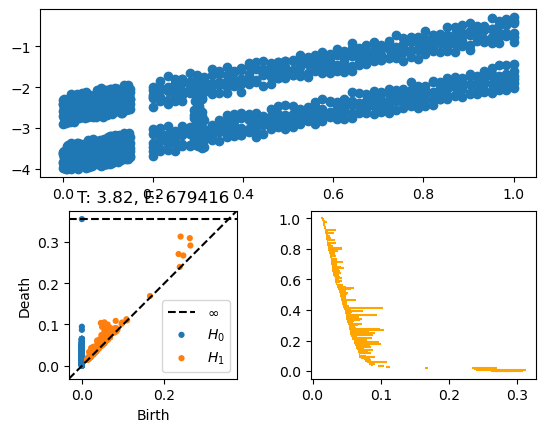

In [222]:
# If SHOW_DATA == True, calculate full persistence diagram/barcode for the data
if SHOW_DATA:
    if RIPS_MAXDIM == 2 and X.shape[0] > 600:
        confirmation = input("Warning: high N chosen with maxdim=2. Continue? [Y/N]")
        if not confirmation or not confirmation[0] in 'Yy':
            sys.exit()
    show_full_persistance(X)

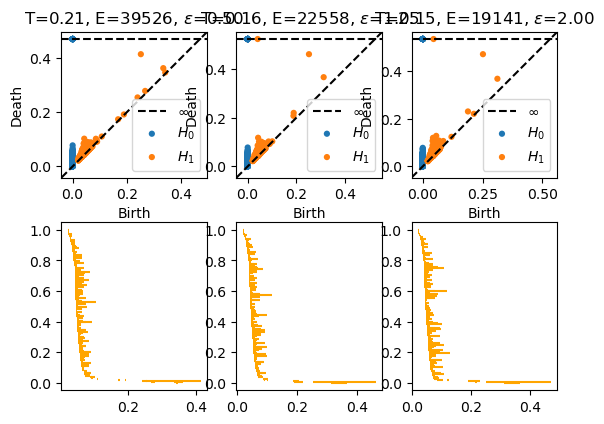

In [97]:
for n, eps in enumerate(np.linspace(MIN_EPS, MAX_EPS, NUM_EPS)):
    elapsed = time.perf_counter()
    # First compute all pairwise distances and do furthest point sampling
    D = pairwise_distances(X, metric='euclidean')
    lambdas = getGreedyPerm(D)
    # Now compute the sparse distance matrix
    DSparse = getApproxSparseDM(lambdas, eps, D)
    # Finally, compute the filtration
    rips = ripser(DSparse, maxdim = RIPS_MAXDIM, distance_matrix = True)
    elapsed = time.perf_counter() - elapsed

    # Make persistance diagram and bar plot
    title = f"T={elapsed:.2f}, E={rips['num_edges']}, $\epsilon$={eps:.2f}"
    make_diag_code_col(n + 1, NUM_EPS, rips['dgms'], title)
    